In [1]:
import glob

import numpy as np
import scipy.optimize as op

import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u

import emcee

from dust_extinction.averages import G03_SMCBar
from dust_extinction.parameter_averages import F19

from measure_extinction.stardata import StarData
from measure_extinction.extdata import ExtData
from measure_extinction.modeldata import ModelData
from measure_extinction.utils.fit_model import FitInfo

from measure_extinction.utils.helpers import get_full_starfile
from measure_extinction.utils.fit_model import get_best_fit_params, get_percentile_params

Specify the location of the model and observed data

In [2]:
file_path = "/home/kgordon/Python_git/extstar_data/"

Define star specific parameters

In [3]:
starname = "m31_e2_j004413.84+414903.9"
fstarname = f"{starname}.dat"
velocity = 0.0 # SMC radial velocity from NED
relband = "ACS_F475W"

Read in the star data

In [4]:
# get the observed reddened star data
reddened_star = StarData(fstarname, path=f"{file_path}/DAT_files/")
band_names = reddened_star.data["BAND"].get_band_names()
data_names = reddened_star.data.keys()

Plot the spectrum

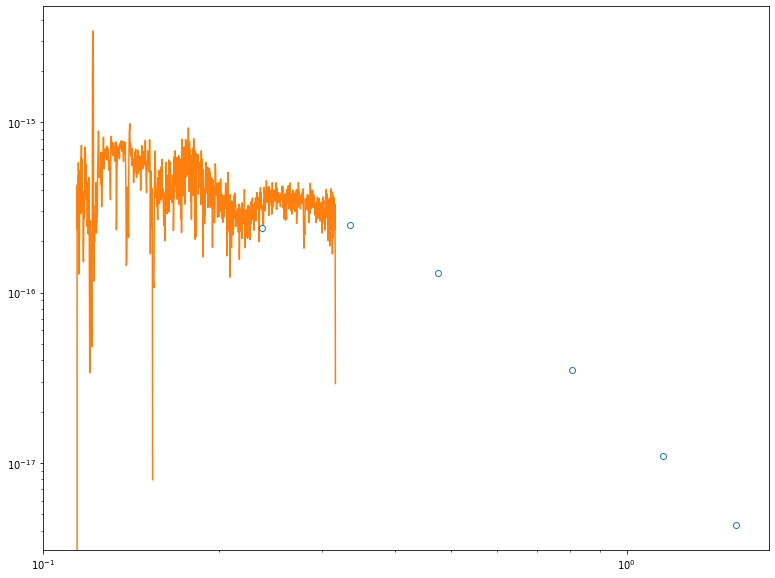

In [5]:
fig, ax = plt.subplots(figsize=(13, 10))
reddened_star.plot(ax)
ax.set_xscale("log")
ax.set_yscale("log")

Get the model data

In [6]:
tlusty_models_fullpath = glob.glob("{}/Models/tlusty_*v10.dat".format(file_path))
# tlusty_models_fullpath = tlusty_models_fullpath[0:10]
tlusty_models = [
    tfile[tfile.rfind("/") + 1 : len(tfile)] for tfile in tlusty_models_fullpath
]

# get the models with just the reddened star band data and spectra
modinfo = ModelData(
    tlusty_models,
    path="{}/Models/".format(file_path),
    band_names=band_names,
    spectra_names=data_names,
)

Setup the fit parameters

In [7]:
# parameter names
pnames = ["logT","logg","logZ","Av","Rv","C2","C3","C4","x0","gamma","HI_gal","HI_mw"]

# initial starting position
#  **customize for each star**
# M31 metallicity -> 1.0 (solar) -> log(Z) = 0.0
params = [4.5, 2.75, 0.0, 0.8, 3.1, 1.3, 2.2, 0.11, 4.6, 0.85, 21.0, 19.0]

# min/max allowed values for each parameter
# some are based on the min/max of the stellar atmosphere grid
plimits = [
        [modinfo.temps_min, modinfo.temps_max],  # log(Teff)
        [modinfo.gravs_min, modinfo.gravs_max],  # log(g)
        [modinfo.mets_min, modinfo.mets_max],    # log(Z)
        [0.0, 4.0],   # Av
        [2.0, 6.0],   # Rv
        [-0.1, 5.0],  # C2
        [0.0, 2.5],   # C3
        [0.0, 1.0],   # C4
        [4.5, 4.9],   # xo
        [0.6, 1.5],   # gamma
        [17.0, 24.0], # log(HI) internal to galaxy
        [17.0, 22.0], # log(HI) MW foreground
    ]

# add Gaussian priors based on prior knowledge
#  sptype -> log(Teff), log(g)
#  galaxy metallicity -> log(Z)
ppriors = {}
ppriors["logT"] = (4.5, 0.1)
ppriors["logg"] = (2.75, 0.1)
ppriors["logZ"] = (0.0, 0.1)

Create the weight arrays based on the observed uncertainties

In [8]:
# cropping info for weights
#  bad regions are defined as those were we know the models do not work
#  or the data is bad
ex_regions = [
    [8.23 - 0.1, 8.23 + 0.1],  # geocoronal line
    [8.7, 10.0],  # bad data from STIS
    [3.55, 3.6],
    [3.80, 3.90],
    [4.15, 4.3],
    [6.4, 6.6],
    [7.1, 7.3],
    [7.45, 7.55],
    [7.65, 7.75],
    [7.9, 7.95],
    [8.05, 8.1],
] / u.micron

weights = {}
for cspec in data_names:
    weights[cspec] = np.full(len(reddened_star.data[cspec].fluxes), 0.0)
    gvals = reddened_star.data[cspec].npts > 0
    weights[cspec][gvals] = 1.0 / reddened_star.data[cspec].uncs[gvals].value

    x = 1.0 / reddened_star.data[cspec].waves
    for cexreg in ex_regions:
        weights[cspec][np.logical_and(x >= cexreg[0], x <= cexreg[1])] = 0.0

# make the photometric bands have higher weight
weights["BAND"] *= 10000.0

Package the fit info needed.  FitInfo class defines the likelihood functions as well.

In [9]:
fitinfo = FitInfo(
    pnames,
    plimits,
    weights,
    parameter_priors=ppriors,
    stellar_velocity=velocity,
)

In [10]:
# check that the initial starting position returns a valid value of lnprob and is within the parameter bounds
fitinfo.check_param_limits(params)
print(fitinfo.lnlike(params, reddened_star, modinfo))
print(fitinfo.lnprior(params))
print(fitinfo.lnprob(params, reddened_star, modinfo, fitinfo))

-1.0636362862058752e+20
0.0
-1.0636362862058752e+20


In [11]:
# simple function to turn the log(likelihood) into the chisqr
#  requied as op.minimize function searchs for the minimum chisqr (not max likelihood like MCMC algorithms)
def nll(*args):
    return -fitinfo.lnprob(*args)

# run the fit
result = op.minimize(
    nll, params, method="Nelder-Mead", options={"maxiter": 1000}, args=(reddened_star, modinfo, fitinfo)
)

# check the fit output
print(result["message"])

Maximum number of iterations has been exceeded.


In [12]:
# save results
params = result["x"]
fit_params = params
params_best = params
pnames_extra = pnames

# print the best fit
for k, val in enumerate(params_best):
    print("{} # {}".format(val, pnames_extra[k]))


4.556846228303538 # logT
2.7487846142781587 # logg
0.0004102885880674229 # logZ
0.8393971863459508 # Av
2.836942690101535 # Rv
0.9728024667395656 # C2
2.1225103546605233 # C3
0.13047810974463747 # C4
4.6765851489521655 # x0
0.8829035139099326 # gamma
21.87659756773612 # HI_gal
21.287415538860856 # HI_mw


Calculate and save the extinction curve

In [13]:
# intrinsic sed
modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo.SED_to_StarData(modsed)

# create an extincion curve and save it
extdata = ExtData()
extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
col_info = {"av": fit_params[3], "rv": fit_params[4]}
extdata.save(starname + "_ext.fits", column_info=col_info)

[3.33932073e+09 3.30104251e+09 3.16176275e+09 ... 1.61028362e+08
 1.60886608e+08 1.60137647e+08] erg / (Angstrom cm2 s)


Plot the spectra

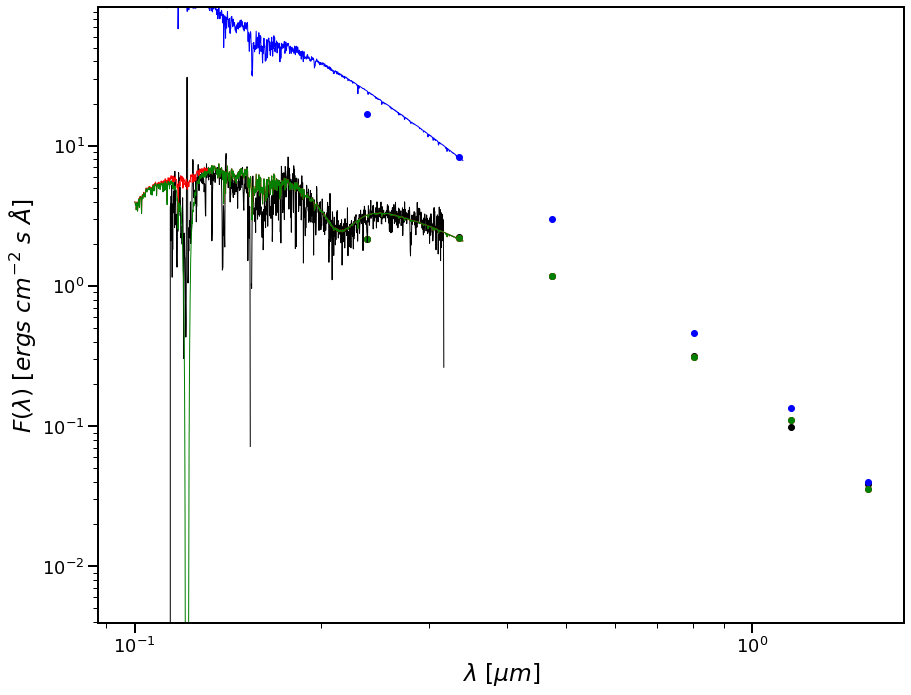

In [14]:
norm_model = np.average(hi_ext_modsed["BAND"])
norm_data = np.average(reddened_star.data["BAND"].fluxes)

# plotting setup for easier to read plots
fontsize = 18
font = {"size": fontsize}
mpl.rc("font", **font)
mpl.rc("lines", linewidth=1)
mpl.rc("axes", linewidth=2)
mpl.rc("xtick.major", width=2)
mpl.rc("xtick.minor", width=2)
mpl.rc("ytick.major", width=2)
mpl.rc("ytick.minor", width=2)

# setup the plot
fig, ax = plt.subplots(figsize=(13, 10))

# plot the bands and all spectra for this star
for cspec in modinfo.fluxes.keys():
    if cspec == "BAND":
        ptype = "o"
    else:
        ptype = "-"

    # ax.plot(reddened_star.data[cspec].waves,
    #        weights[cspec], 'k-')

    ax.plot(
        reddened_star.data[cspec].waves,
        reddened_star.data[cspec].fluxes / norm_data,
        "k" + ptype,
        label="data",
    )

    # print(reddened_star.data[cspec].waves)
    # print(modinfo.waves[cspec])

    ax.plot(
        modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=cspec
    )
    ax.plot(
        modinfo.waves[cspec],
        ext_modsed[cspec] / norm_model,
        "r" + ptype,
        label=cspec,
    )
    ax.plot(
        modinfo.waves[cspec],
        hi_ext_modsed[cspec] / norm_model,
        "g" + ptype,
        label=cspec,
    )

# finish configuring the plot
ax.set_ylim(8e4 / norm_model, 2e9 / norm_model)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# ax.legend()

# use the whitespace better
fig.tight_layout()

Plot the extinction curve

True


/home/kgordon/Python_git/measure_extinction/measure_extinction/extdata.py:581: UserWarning: attempt to normalize a non-E(lambda-V) curve with A(V)
  warnings.warn(


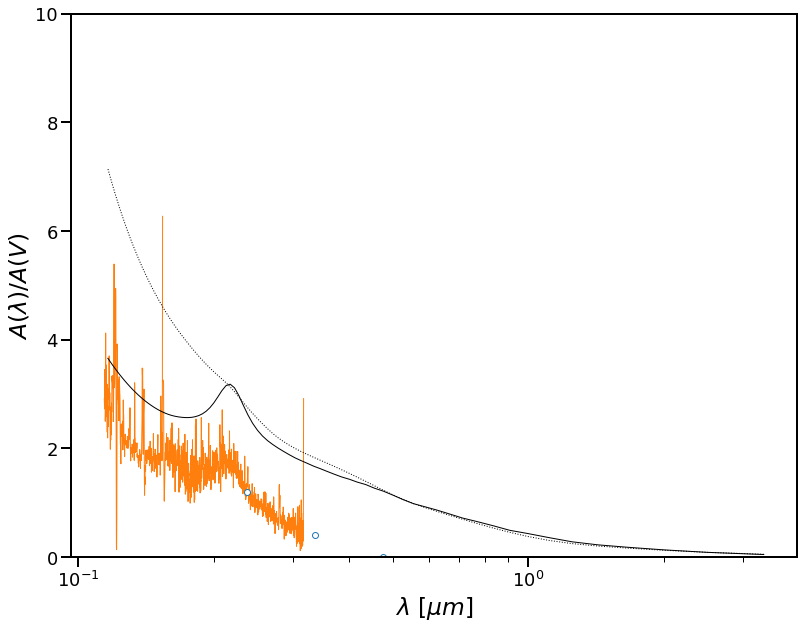

In [15]:
fig, ax = plt.subplots(figsize=(13, 10))

# convert from E(l-V) to A(l)/A(V)
print(extdata.type_rel_band != "V")
extdata.columns["AV"] = (params[3], 0.0)
extdata.trans_elv_alav()

extdata.plot(ax) #, alax=True)
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylim(0.0, 10.0)
ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# plot known exitnction curves
mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
smcbar = G03_SMCBar()
ax.plot(1.0 / mod_x, smcbar(mod_x), "k:")

f19_rv31 = F19(Rv=3.1)
ax.plot(1.0 / mod_x, f19_rv31(mod_x), "k-")

Run emcee MCMC sampler to define uncertainties (bonus section)

In [16]:
p0 = params
ndim = len(p0)

#nwalkers = 2 * ndim
#nsteps = 50
#burn = 50

nwalkers = 100
nsteps = 500
burn = 500

# setting up the walkers to start "near" the inital guess
p = [p0 * (1 + 0.01 * np.random.normal(0, 1.0, ndim)) for k in range(nwalkers)]

# setup the sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, fitinfo.lnprob, args=(reddened_star, modinfo, fitinfo)
)

# burn in the walkers
pos, prob, state = sampler.run_mcmc(p, burn)

# rest the sampler
sampler.reset()

# do the full sampling
pos, prob, state = sampler.run_mcmc(pos, nsteps, rstate0=state)

# create the samples variable for later use
samples = sampler.chain.reshape((-1, ndim))

# get the best fit values
pnames_extra = pnames + ["E(B-V)", "N(HI)/A(V)", "N(HI)/E(B-V)"]
params_best = get_best_fit_params(sampler)
fit_params = params_best
print("best params")
print(params_best)

# get the 16, 50, and 84 percentiles
params_per = get_percentile_params(samples)

# save the best fit and p50 +/- uncs values to a file
# save as a single row table to provide a uniform format
#f = open(out_basename + "_fit_params.dat", "w")
#f.write("# best fit, p50, +unc, -unc\n")
for k, val in enumerate(params_per):
    print(
        "{} {} {} {} # {}".format(
            params_best[k], val[0], val[1], val[2], pnames_extra[k]
        )
    )
#    f.write(
#        "{} {} {} {} # {}\n".format(
#            params_best[k], val[0], val[1], val[2], pnames_extra[k]
#        )
#    )


best params
[4.73971877e+00 2.28204242e+00 4.95086546e-04 8.93708840e-01
 2.78200018e+00 1.18433118e+00 1.36641905e+00 1.18003314e-01
 4.67689774e+00 7.11234472e-01 2.17881178e+01 1.70005284e+01
 3.21246866e-01 6.86944705e+21 1.91108029e+22]
4.739718766278614 4.735992008020091 0.002962642839430707 0.042123562215192756 # logT
2.282042423200327 2.295975054485922 0.09683431542810172 0.014369793993364688 # logg
0.0004950865458213704 0.00043537039683465815 4.6871958470630804e-05 1.1164474791338762e-05 # logZ
0.8937088404684818 0.8950446889830315 0.004785035044880037 0.012509160225494975 # Av
2.7820001839920563 2.788397610848429 0.0032591690092909076 0.005044566758924951 # Rv
1.1843311836071528 1.1809779761570818 0.005237206062441713 0.05961106945768879 # C2
1.3664190493626316 1.436647994867327 0.14570456529707076 0.056980266693972714 # C3
0.11800331372338145 0.14605625339905648 0.011618033163702496 0.026546915149239 # C4
4.67689774170937 4.681528715276627 0.012941667474633434 0.003303171194

In [17]:
# intrinsic sed
modsed = modinfo.stellar_sed(fit_params[0:3], velocity=velocity)

# dust_extinguished sed
ext_modsed = modinfo.dust_extinguished_sed(fit_params[3:10], modsed)

# hi_abs sed
hi_ext_modsed = modinfo.hi_abs_sed(
    fit_params[10:12], [velocity, 0.0], ext_modsed
)

# create a StarData object for the best fit SED
modsed_stardata = modinfo.SED_to_StarData(modsed)

# create an extincion curve and save it
extdata = ExtData()
extdata.calc_elx(reddened_star, modsed_stardata, rel_band=relband)
col_info = {"av": fit_params[3], "rv": fit_params[4]}
extdata.save(starname + "_ext.fits", column_info=col_info)

[6.51254683e+09 6.47252319e+09 6.43432636e+09 ... 2.29751412e+08
 2.33863149e+08 2.32981204e+08] erg / (Angstrom cm2 s)


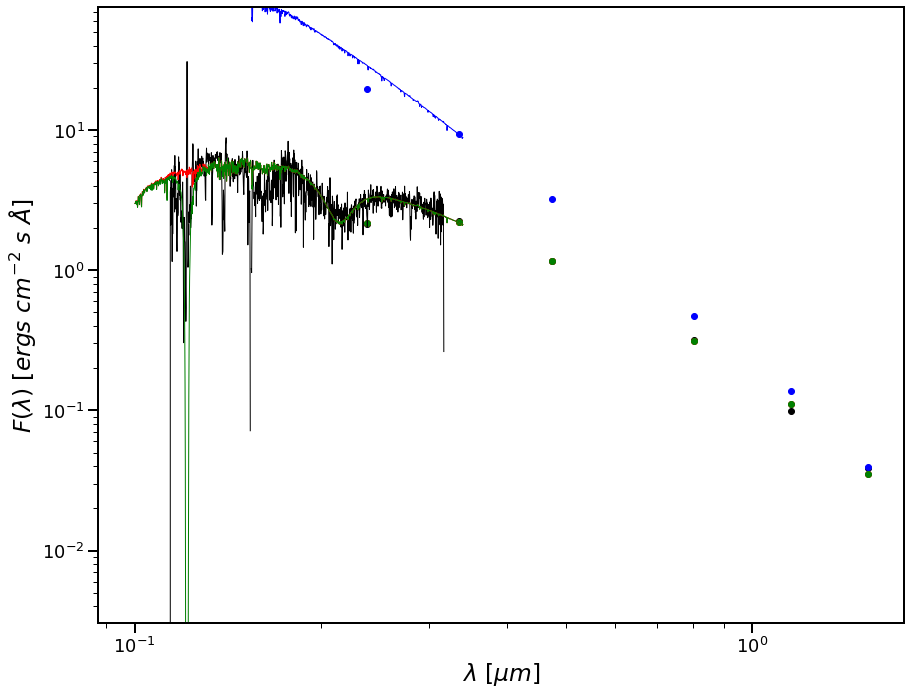

In [18]:
norm_model = np.average(hi_ext_modsed["BAND"])
norm_data = np.average(reddened_star.data["BAND"].fluxes)

# plotting setup for easier to read plots
fontsize = 18
font = {"size": fontsize}
mpl.rc("font", **font)
mpl.rc("lines", linewidth=1)
mpl.rc("axes", linewidth=2)
mpl.rc("xtick.major", width=2)
mpl.rc("xtick.minor", width=2)
mpl.rc("ytick.major", width=2)
mpl.rc("ytick.minor", width=2)

# setup the plot
fig, ax = plt.subplots(figsize=(13, 10))

# plot the bands and all spectra for this star
for cspec in modinfo.fluxes.keys():
    if cspec == "BAND":
        ptype = "o"
    else:
        ptype = "-"

    # ax.plot(reddened_star.data[cspec].waves,
    #        weights[cspec], 'k-')

    ax.plot(
        reddened_star.data[cspec].waves,
        reddened_star.data[cspec].fluxes / norm_data,
        "k" + ptype,
        label="data",
    )

    # print(reddened_star.data[cspec].waves)
    # print(modinfo.waves[cspec])

    ax.plot(
        modinfo.waves[cspec], modsed[cspec] / norm_model, "b" + ptype, label=cspec
    )
    ax.plot(
        modinfo.waves[cspec],
        ext_modsed[cspec] / norm_model,
        "r" + ptype,
        label=cspec,
    )
    ax.plot(
        modinfo.waves[cspec],
        hi_ext_modsed[cspec] / norm_model,
        "g" + ptype,
        label=cspec,
    )

# finish configuring the plot
ax.set_ylim(8e4 / norm_model, 2e9 / norm_model)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylabel(r"$F(\lambda)$ [$ergs\ cm^{-2}\ s\ \AA$]", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# ax.legend()

# use the whitespace better
fig.tight_layout()

True


/home/kgordon/Python_git/measure_extinction/measure_extinction/extdata.py:581: UserWarning: attempt to normalize a non-E(lambda-V) curve with A(V)
  warnings.warn(


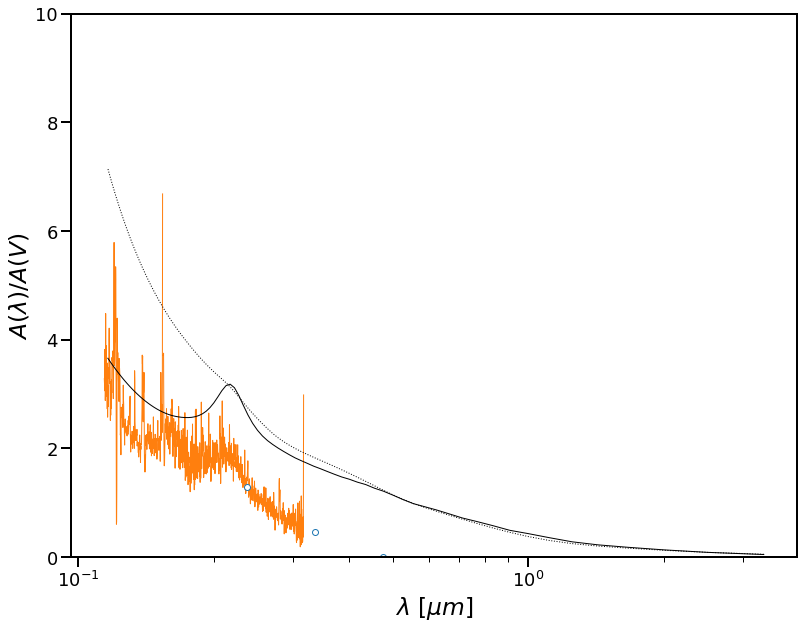

In [19]:
fig, ax = plt.subplots(figsize=(13, 10))

# convert from E(l-V) to A(l)/A(V)
print(extdata.type_rel_band != "V")
extdata.columns["AV"] = (params[3], 0.0)
extdata.trans_elv_alav()

extdata.plot(ax) #, alax=True)
ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$ [$\mu m$]", fontsize=1.3 * fontsize)
ax.set_ylim(0.0, 10.0)
ax.set_ylabel(r"$A(\lambda)/A(V)$", fontsize=1.3 * fontsize)
ax.tick_params("both", length=10, width=2, which="major")
ax.tick_params("both", length=5, width=1, which="minor")

# plot known exitnction curves
mod_x = np.arange(0.3, 8.7, 0.1) / u.micron
smcbar = G03_SMCBar()
ax.plot(1.0 / mod_x, smcbar(mod_x), "k:")

f19_rv31 = F19(Rv=3.1)
ax.plot(1.0 / mod_x, f19_rv31(mod_x), "k-")